# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [2]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [3]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from IPython import display

import nltk
from nltk.corpus import brown
from nltk.probability import ConditionalFreqDist,ConditionalProbDist,MLEProbDist
import itertools

from sklearn.model_selection import train_test_split


# interactive display
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [5]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [6]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [7]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [8]:
activity_labels = {0: 'sit on bed', 1: 'sit on chair', 2: 'lying', 3: 'ambulating'}

# Iterate through X_given_y to retrieve activities for each state
for state, observations in enumerate(X_given_y):
    print(f"Activities for State {state + 1}: {activity_labels[state]}")
    # Assuming you want to print the activities for each state
    for observation in observations:
        # Process observation if needed
        print(observation)  # Print or process the observation associated with this state

Activities for State 1: sit on bed
[[ 2.3685e-01  1.0082e+00  3.1928e-02 -5.5000e+01  1.5033e+00  9.2475e+02]]
[[ 2.3685e-01  1.0082e+00  3.1928e-02 -5.6500e+01  3.5680e+00  9.2475e+02]]
[[ 2.3685e-01  1.0082e+00  3.1928e-02 -5.8000e+01  4.8550e+00  9.2075e+02]]
[[ 2.3685e-01  1.0082e+00  3.1928e-02 -5.6500e+01  3.9653e+00  9.2425e+02]]
[[ 2.3685e-01  1.0082e+00  3.1928e-02 -5.9500e+01  2.9452e-01  9.2025e+02]]
[[ 2.3685e-01  1.0082e+00  3.1928e-02 -5.8000e+01  7.0256e-01  9.2175e+02]]
[[ 2.3685e-01  1.0082e+00  3.1928e-02 -5.7000e+01  2.8379e+00  9.2275e+02]]
[[ 2.7203e-01  9.9674e-01  9.1224e-03 -5.5500e+01  1.1259e+00  9.2475e+02]]
[[ 2.7203e-01  9.9674e-01  9.1224e-03 -5.6500e+01  4.1709e+00  9.2375e+02]]
[[ 2.7203e-01  9.9674e-01  9.1224e-03 -5.6500e+01  3.8626e+00  9.2425e+02]]
[[ 2.7203e-01  9.9674e-01  9.1224e-03 -5.6000e+01  2.4774e+00  9.2325e+02]]
[[ 2.7203e-01  9.9674e-01  9.1224e-03 -5.8000e+01  4.1832e+00  9.2125e+02]]
[[ 2.7203e-01  9.9674e-01  9.1224e-03 -5.6000e+01  1.

In [9]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

In [10]:
from hmmlearn import hmm

# Define the HMM model - setting initialization parameters to prevent re-estimation
model = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', random_state=42, init_params='')
model.means_ = means
model.covars_ = diagonal_covars

# Flatten the training and test sequences separately
flat_X_train = [item for sublist in X_by_seq_tr for item in sublist]
flat_X_test = [item for sublist in X_by_seq_test for item in sublist]

# Calculate lengths for both training and test sequences
lengths_train = [len(seq) for seq in X_by_seq_tr]
lengths_test = [len(seq) for seq in X_by_seq_test]

# Fit the model to the training data
model.fit(flat_X_train, lengths=lengths_train)

# Predict hidden states for the test data
hidden_states_test = model.predict(flat_X_test, lengths=lengths_test)


In [11]:
from sklearn.metrics import accuracy_score
# Flatten true states for the test data
true_states_test = [state for seq_states in y_by_seq_test for state in seq_states]

# Calculate accuracy score
accuracy = accuracy_score(true_states_test, hidden_states_test)

print(f"Accuracy Score: {accuracy:.4f}")

Accuracy Score: 0.8105


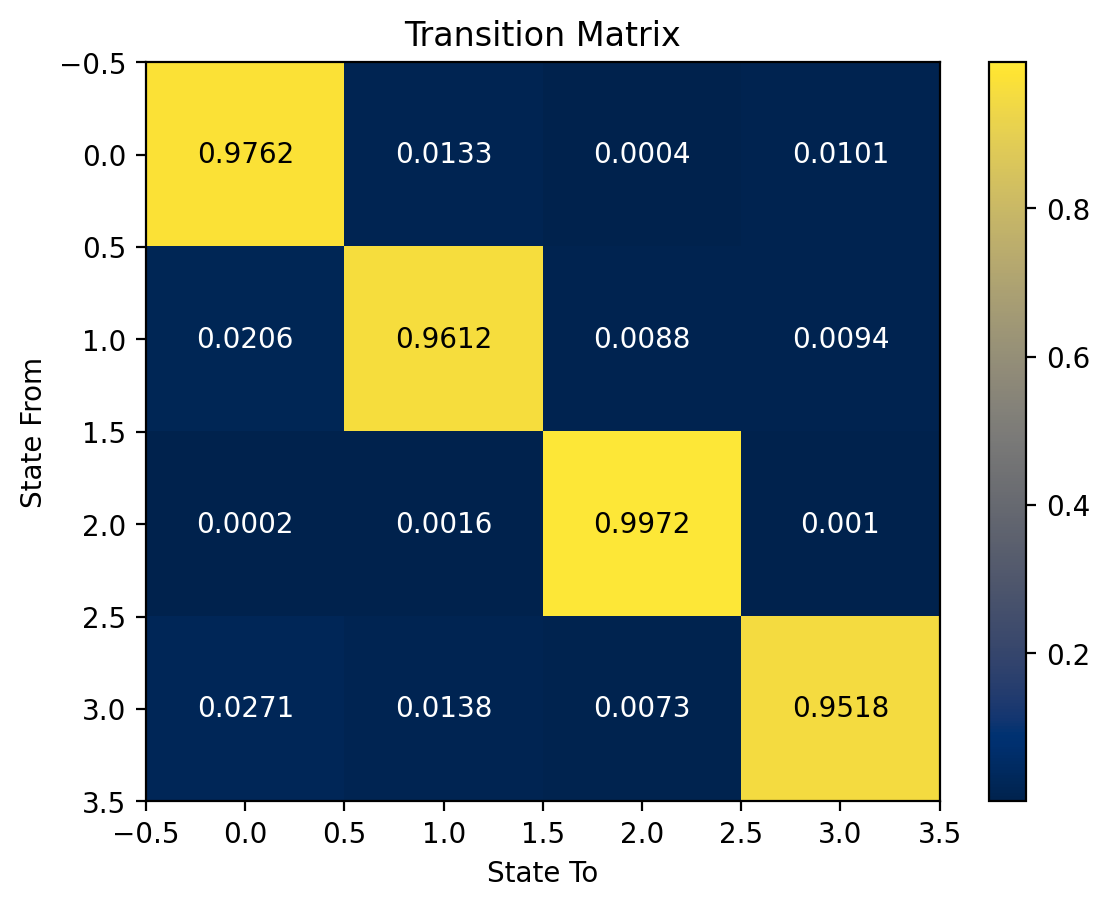

In [38]:
fig, ax = plt.subplots()

for i in range(4):
    for j in range(4):
        if i == j:
            text = ax.text(j, i, round(model.transmat_[i, j], 4),
                       ha="center", va="center", color="black")
        else:
            text = ax.text(j, i, round(model.transmat_[i, j], 4),
                       ha="center", va="center", color="w")


img = ax.imshow(model.transmat_, aspect='auto', cmap='cividis')
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')
plt.colorbar(img, ax=ax);

In [13]:
means = model.means_
print(means)

[[ 3.20130906e-01  9.68790624e-01  3.57921888e-02 -5.85151764e+01
   3.24265502e+00  9.22753640e+02]
 [ 6.49284993e-01  8.31792594e-01  8.76822717e-02 -5.92144962e+01
   3.34171197e+00  9.22673047e+02]
 [ 1.09158611e+00  4.01066572e-03 -2.56477699e-02 -5.84310350e+01
   3.31995727e+00  9.22798589e+02]
 [ 1.08343443e-01  9.74893722e-01  5.43220128e-02 -5.65326423e+01
   3.02393230e+00  9.22800761e+02]]


In [14]:
# Assuming 'means' contains emission distribution means for each state (shape: n_states x n_features)
# Also assuming 'activities' represent activity labels

# Define your feature names
feature_names = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]
activity_labels = {1: "sit on bed", 2: "sit on chair", 3: "lying", 4: "ambulating"}  # Mapping activity labels to their descriptions
    
# Print feature means for each state with associated activity labels
for state_means, activity_label in zip(means, activity_labels.values()):
    print(f"Activity Label: {activity_label}")
    for feature_idx, mean_value in enumerate(state_means):
        print(f"Feature '{feature_names[feature_idx]}': Mean = {mean_value:.4f}")

Activity Label: sit on bed
Feature 'frontal acc': Mean = 0.3201
Feature 'vertical acc': Mean = 0.9688
Feature 'lateral acc': Mean = 0.0358
Feature 'RSSI': Mean = -58.5152
Feature 'phase': Mean = 3.2427
Feature 'frequency': Mean = 922.7536
Activity Label: sit on chair
Feature 'frontal acc': Mean = 0.6493
Feature 'vertical acc': Mean = 0.8318
Feature 'lateral acc': Mean = 0.0877
Feature 'RSSI': Mean = -59.2145
Feature 'phase': Mean = 3.3417
Feature 'frequency': Mean = 922.6730
Activity Label: lying
Feature 'frontal acc': Mean = 1.0916
Feature 'vertical acc': Mean = 0.0040
Feature 'lateral acc': Mean = -0.0256
Feature 'RSSI': Mean = -58.4310
Feature 'phase': Mean = 3.3200
Feature 'frequency': Mean = 922.7986
Activity Label: ambulating
Feature 'frontal acc': Mean = 0.1083
Feature 'vertical acc': Mean = 0.9749
Feature 'lateral acc': Mean = 0.0543
Feature 'RSSI': Mean = -56.5326
Feature 'phase': Mean = 3.0239
Feature 'frequency': Mean = 922.8008


## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [15]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [16]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier